# Starbucks Capstone Project
## Model Training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as metrics
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
train_dataloader, valid_dataloader, test_dataloader = \
    torch.load('dataloaders.pt')

In [3]:
def validate(model, criterion, dataloader=valid_dataloader):
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        y_true = []
        y_pred = []
        for features, targets in dataloader:
            prediction = model(features)
            
            prediction = prediction.view(-1,2)
            targets = targets.view(-1)
            valid_loss += criterion(prediction, targets)

            prediction = torch.softmax(prediction, dim=1)
            _, prediction = prediction.topk(1, dim=1)
            prediction = prediction.squeeze()

            y_pred.extend(prediction.view(-1))
            y_true.extend(targets.view(-1))

        # normalize the loss
        valid_loss /= len(dataloader)
        valid_loss = valid_loss.item()

        # Calculate the metrics
        accuracy = metrics.accuracy_score(y_true, y_pred)
        c_matrix = metrics.confusion_matrix(y_true, y_pred)
        precision = metrics.precision_score(y_true, y_pred)
        recall = metrics.recall_score(y_true, y_pred)

        model.train()

        return valid_loss, accuracy, precision, \
               recall, c_matrix

In [8]:
class FNN(nn.Module):
    def __init__(self, input_size):
        super(FNN, self).__init__()
        self.input_size = input_size

        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )


    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.net(x)

        return x


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, hidden_layers=2, output_size=2):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        ## Build the Recurrent Network
        self.rnn = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=hidden_layers,
                          batch_first=True)

        self.hidden_tensor = torch.zeros(hidden_layers, 1, hidden_size) \
                             .uniform_(-3e-3, 3e-3)

        self.fnn = nn.Sequential(
            nn.Linear(128, 2),
        )

    def forward(self, x):
        batch_size = x.shape[0]
        seq_length = x.shape[1]

        ## Feed the RNN
        h = self.init_hidden(batch_size)
        x, h = self.rnn(x, h)

        ## Feed the Classifier
        x = x.contiguous().view(-1, self.hidden_size)
        x = self.fnn[-1](x)

        ## Stack the results
        x = x.view(batch_size, seq_length, self.output_size)

        return x

    def init_hidden(self, batch_size):
        self.hidden_tensor.repeat(1, batch_size, 1)

In [15]:
def train(model, criterion, optimizer, model_name, dataloader=train_dataloader, epochs=100):
    train_loss = []
    valid_loss = []
    min_valid_loss = np.inf
    ## Perform N epochs of training
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for batch, (features, targets) in enumerate(dataloader):
            ## Train the network
            optimizer.zero_grad()
            prediction = model(features)
            prediction = prediction.view(-1,2)
            targets = targets.view(-1)
            loss = criterion(prediction, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Normalize the training loss
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)
        

        # Validate
        metrics = validate(model, criterion)
        valid_loss.append(metrics[0])
        print(f'Epoch {epoch} train loss: {train_loss[-1]}, valid loss: {valid_loss[-1]}, acc: {metrics[1]}')

        # Save the model if valid_loss has decreased
        if valid_loss[-1] < min_valid_loss:
            min_valid_loss = valid_loss[-1]
            torch.save(model.state_dict(), f'{model_name}.pt')

    return train_loss, valid_loss

## FNN

In [23]:
FNN_classifier = FNN(input_size=16)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FNN_classifier.parameters(), lr=0.001, weight_decay=0.001)

In [24]:
FNN_loss = train(FNN_classifier,
                    criterion = criterion,
                    optimizer = optimizer,
                    model_name='FNN',
                    epochs=20)

Epoch 1 train loss: 0.25447211193678965, valid loss: 0.22391174733638763, acc: 0.8828092243186583
Epoch 2 train loss: 0.23126464591703222, valid loss: 0.22305350005626678, acc: 0.8827044025157232
Epoch 3 train loss: 0.23128704973800698, valid loss: 0.22335051000118256, acc: 0.8817610062893082
Epoch 4 train loss: 0.2304170929531955, valid loss: 0.2233753800392151, acc: 0.8825995807127882
Epoch 5 train loss: 0.23060728673210096, valid loss: 0.22279196977615356, acc: 0.8829140461215933
Epoch 6 train loss: 0.2307764678893976, valid loss: 0.2251453995704651, acc: 0.8820754716981132
Epoch 7 train loss: 0.23027487986501138, valid loss: 0.22578328847885132, acc: 0.8787211740041929
Epoch 8 train loss: 0.23037814599784776, valid loss: 0.22313667833805084, acc: 0.8810272536687631
Epoch 9 train loss: 0.2304212160820338, valid loss: 0.2230014055967331, acc: 0.8822851153039832
Epoch 10 train loss: 0.23019732714597904, valid loss: 0.2239803820848465, acc: 0.8824947589098533
Epoch 11 train loss: 0.230

## RNN

In [25]:
RNN_classifier = RNN(input_size=16, output_size=2, hidden_size=128, hidden_layers=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(RNN_classifier.parameters(), lr=0.001, weight_decay=0.001)

In [26]:
RNN_loss = train(RNN_classifier,
                    criterion = criterion,
                    optimizer = optimizer,
                    model_name='RNN',
                    epochs=20)

Epoch 1 train loss: 0.2653205341579926, valid loss: 0.23105458915233612, acc: 0.8753668763102725
Epoch 2 train loss: 0.23530998672522493, valid loss: 0.22714219987392426, acc: 0.8840670859538784
Epoch 3 train loss: 0.23517175883653774, valid loss: 0.22848477959632874, acc: 0.8830188679245283
Epoch 4 train loss: 0.23435473131324777, valid loss: 0.22661159932613373, acc: 0.880817610062893
Epoch 5 train loss: 0.23318309089796027, valid loss: 0.22631755471229553, acc: 0.8821802935010482
Epoch 6 train loss: 0.23333861311925716, valid loss: 0.2260482758283615, acc: 0.8819706498951781
Epoch 7 train loss: 0.23253282406671563, valid loss: 0.22645923495292664, acc: 0.8816561844863732
Epoch 8 train loss: 0.23223774928842958, valid loss: 0.22541265189647675, acc: 0.8829140461215933
Epoch 9 train loss: 0.2316709273125059, valid loss: 0.22421443462371826, acc: 0.8824947589098533
Epoch 10 train loss: 0.2314543248570744, valid loss: 0.22363555431365967, acc: 0.8809224318658281
Epoch 11 train loss: 0.2

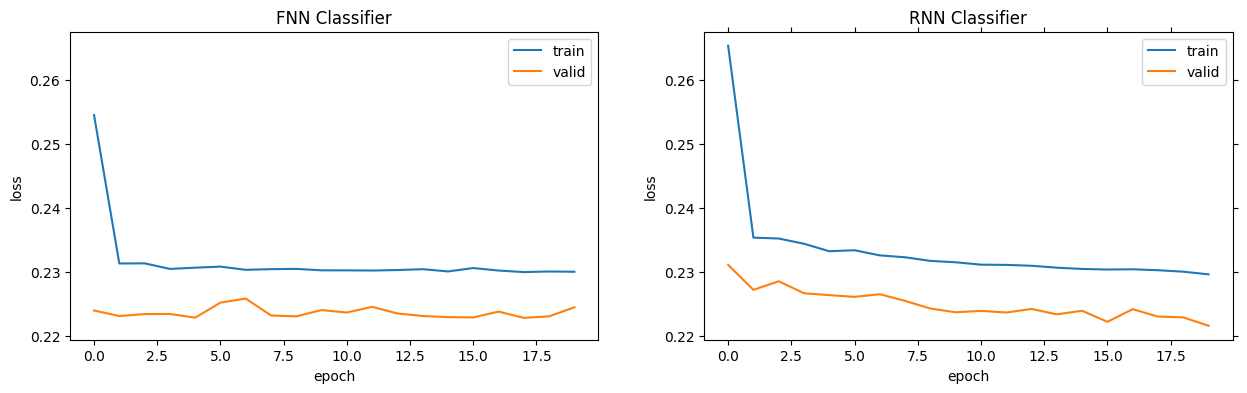

In [38]:
fig, (ax0, ax1) = plt.subplots(
    figsize=(15,4), nrows=1, ncols=2, sharey=True)

ax0.plot(FNN_loss[0], label='train')
ax0.plot(FNN_loss[1], label='valid')
ax0.set_title('FNN Classifier')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend()

ax1.plot(RNN_loss[0], label='train')
ax1.plot(RNN_loss[1], label='valid')
ax1.set_title('RNN Classifier')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend()
ax1.tick_params(reset=True)

plt.savefig('figures/loss.png', bbox_inches='tight')
plt.show()

In [28]:
FNN_classifier.load_state_dict(torch.load('FNN.pt'))
RNN_classifier.load_state_dict(torch.load('RNN.pt'))

<All keys matched successfully>

In [30]:
l_loss, l_acc, l_prec, l_rec, l_cmatrix = validate(FNN_classifier, criterion, test_dataloader)
r_loss, r_acc, r_prec, r_rec, r_cmatrix = validate(RNN_classifier, criterion, test_dataloader)

In [35]:
print(f'FNN loss: {l_loss}, FNN acc: {l_acc}, FNN prec: {l_prec}, FNN rec: {l_rec}')
print(f'FNN confusion matrix: \n {l_cmatrix}')

FNN loss: 0.2298329770565033, FNN acc: 0.8774910845395427, FNN prec: 0.5996711878339499, FNN rec: 0.882637628554144
FNN confusion matrix: 
 [[6907  974]
 [ 194 1459]]


In [36]:
print(f'RNN loss: {r_loss}, RNN acc: {r_acc}, RNN prec: {r_prec}, RNN rec: {r_rec}')
print(f'RNN confusion matrix: \n {r_cmatrix}')

RNN loss: 0.22889035940170288, RNN acc: 0.8771764212292846, RNN prec: 0.6062610229276896, RNN rec: 0.8318209316394435
RNN confusion matrix: 
 [[6988  893]
 [ 278 1375]]
